## PPI-Network: Analysis Of The Graph Structure And The Effects Of Removing Edges

In [1]:
import os
import pandas as pd
import networkx as nx
from collections import defaultdict
import random
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import math

random.seed(42)

In [2]:
data_dir = "data/DrugCombDB"
ppi_df = pd.read_excel(os.path.join(data_dir, 'protein-protein_network.xlsx'))
ppi_df = ppi_df[['protein_a', 'protein_b']]
cpi_df = pd.read_csv(os.path.join(data_dir, 'cell_protein.csv'))
dpi_df = pd.read_csv(os.path.join(data_dir, 'drug_protein.csv'))
drug_combo_df = pd.read_csv(os.path.join(data_dir, 'drug_combinations.csv'))

In [3]:
used_drugs = list(set(drug_combo_df['drug1_db']) | set(drug_combo_df['drug2_db']))
targeted_cells = list(set(drug_combo_df['cell']))
targeted_proteins = list(set(cpi_df.loc[cpi_df['cell'].isin(targeted_cells), 'protein']))

In [4]:
def build_randomized_graph(drop_ratio):
    tuples = [tuple(x) for x in ppi_df.values]
    remove_edges = random.sample(tuples, int(len(tuples)*drop_ratio))
    if drop_ratio == 0:
        assert remove_edges == [] or None, "The number of edges to be removed is not none despite drop_ratio being 0"
    g = nx.Graph()
    g.add_edges_from(tuples)
    g.remove_edges_from(remove_edges)
    return g

In [5]:
graphs = defaultdict()
drop_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for ratio in drop_ratios:
    graphs[ratio] = build_randomized_graph(ratio)

ppi_graphs = list(graphs.values())
labels = [f"{100*x}% Dropped" for x in list(graphs.keys())]

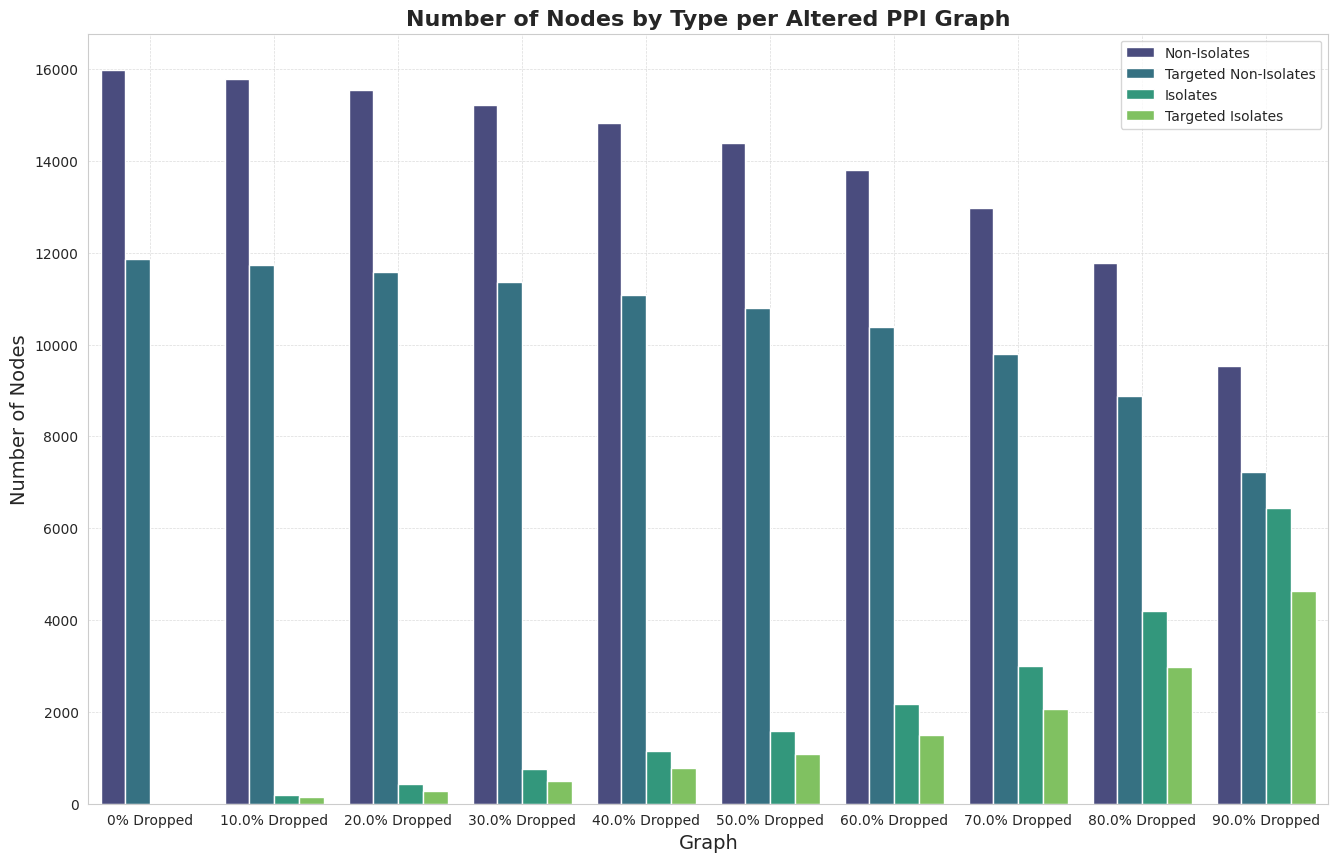

In [6]:
n_nodes = []
n_isolates = []
n_targeted_isolates = []
n_targeted_non_isolates = []
for graph in ppi_graphs:
    isolates = list(nx.isolates(graph))
    non_isolates = [node for node, degree in graph.degree() if degree > 0]
    targeted_isolates = [node for node in targeted_proteins if node in isolates]
    targeted_non_isolates = [node for node in targeted_proteins if node in non_isolates]
    n_targeted_non_isolates.append(len(targeted_non_isolates))
    n_targeted_isolates.append(len(targeted_isolates))
    n_nodes.append(len(non_isolates))
    n_isolates.append(len(isolates))
    
graph_ratio = {
    "Graph": labels,
    "Non-Isolates": n_nodes,
    "Targeted Non-Isolates": n_targeted_non_isolates,
    "Isolates": n_isolates,
    "Targeted Isolates": n_targeted_isolates
}

ratio_df = pd.DataFrame(graph_ratio)
melted_ratio_df = ratio_df.melt(id_vars='Graph', var_name="Node Type", value_name="Count")

plt.figure(figsize=(16, 10))
sns.barplot(data=melted_ratio_df, x="Graph", y="Count", hue="Node Type", palette="viridis")
plt.xlabel("Graph", fontsize=14)
plt.ylabel("Number of Nodes", fontsize=14)
plt.title("Number of Nodes by Type per Altered PPI Graph", fontsize=16, fontweight='bold')
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()

# Show plot
plt.show()

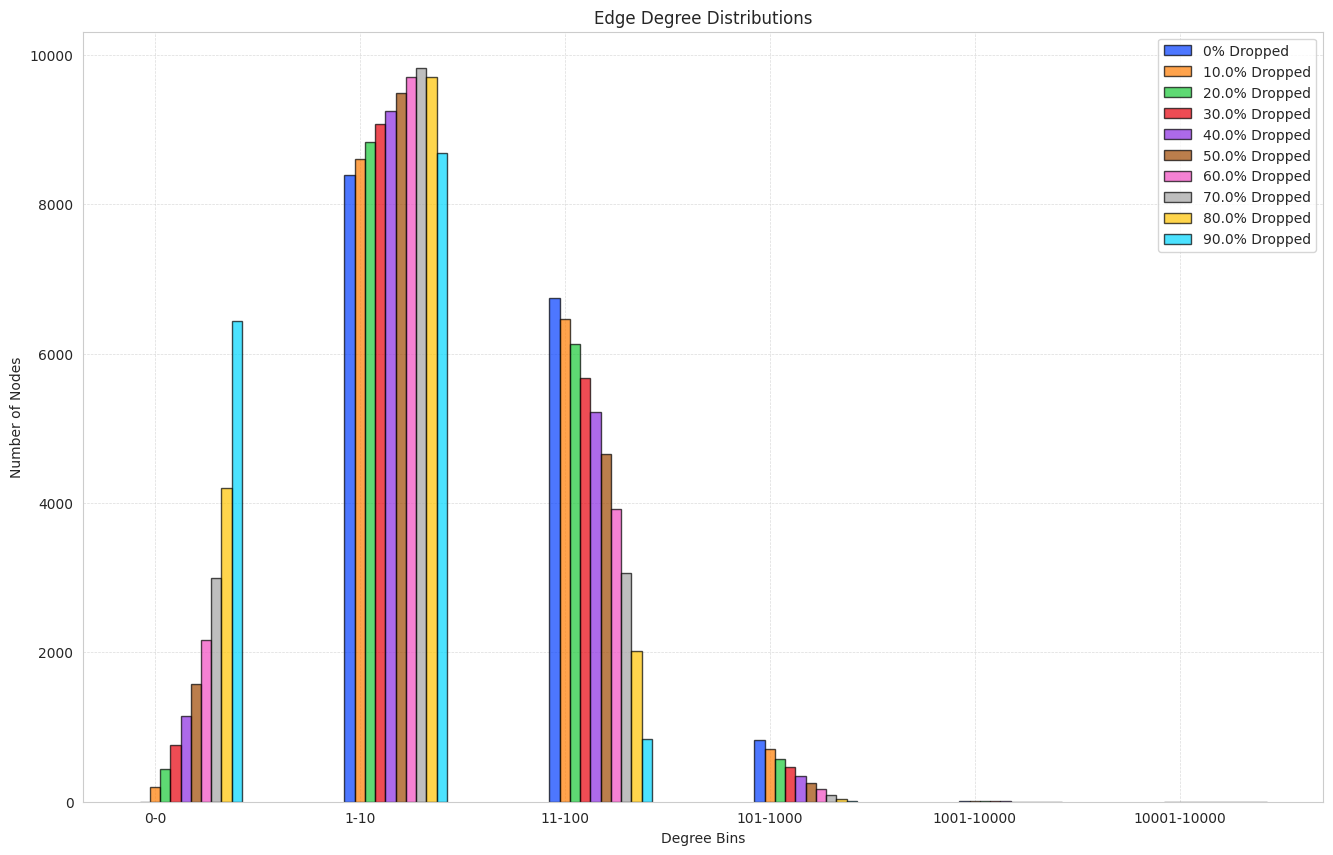

In [7]:
# Calculate the degree histogram (Plot Template Generated Using ChatGPT)
colors = sns.color_palette("bright", n_colors=len(ppi_graphs))

# Plot the degree distribution as a bar plot
bin_edges = [0, 1, 11, 101, 1001, 10001, max(len(nx.degree_histogram(ppi_graphs[0])), 10001)]
bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]-1}" for i in range(len(bin_edges)-1)]
bar_width = 0.05

# Aggregate counts within each bin
plt.figure(figsize=(16, 10))

# Offset positions for side-by-side bars
x_positions = np.arange(len(bin_labels))

for i, G in enumerate(ppi_graphs):
    # Calculate the degree histogram for the graph
    degree_counts = nx.degree_histogram(G)
    
    # Aggregate counts within each bin
    binned_counts = []
    for j in range(len(bin_edges) - 1):
        start, end = bin_edges[j], bin_edges[j+1]
        count = sum(degree_counts[d] for d in range(start, min(end, len(degree_counts))))
        binned_counts.append(count)
    
    # Plot the binned degree distribution with offset bars
    plt.bar(x_positions + i * bar_width, binned_counts, color=colors[i], edgecolor='black', 
            width=bar_width, label=labels[i], alpha=0.7)

# Set x-ticks to be at the center of the grouped bars
plt.xticks(x_positions + bar_width, bin_labels)

# Labels and title
plt.xlabel("Degree Bins")
plt.ylabel("Number of Nodes")
plt.title("Edge Degree Distributions")
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()

In [8]:
clustering_data = []
for label, graph in zip(labels, ppi_graphs):
    local_clustering_coeffs = list(nx.clustering(graph).values())
    for coeff in local_clustering_coeffs:
        clustering_data.append({"Graph": label, "Local Clustering Coefficient": coeff})

clustering_df = pd.DataFrame(clustering_data)

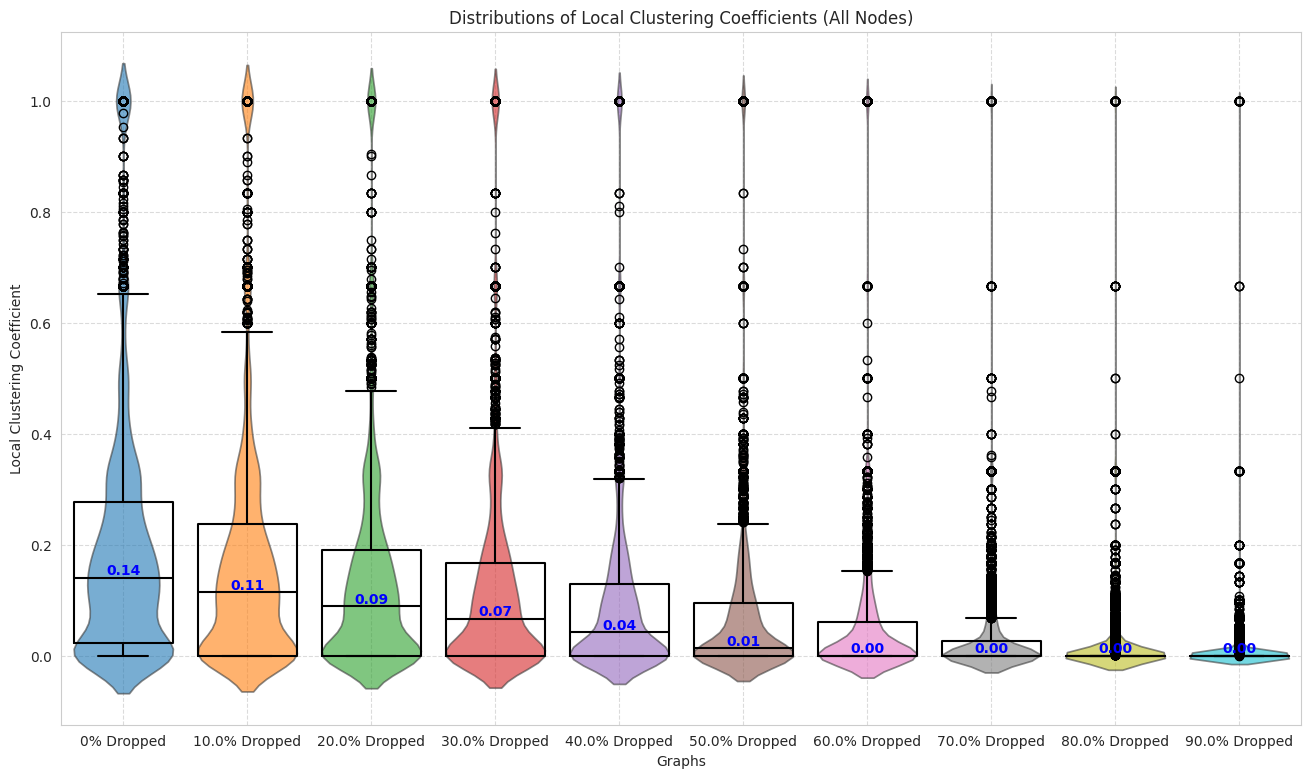

In [9]:
# Plot the distribution using a kernel density plot (Template generated by ChatGPT)
plt.figure(figsize=(16, 9))
sns.boxplot(data=clustering_df, x="Graph", y="Local Clustering Coefficient", legend=False, fill=False, color='black')
sns.violinplot(data=clustering_df, x="Graph", y="Local Clustering Coefficient", hue='Graph', inner=None, alpha=0.6, legend=False, saturation=1)

# Calculate medians and add annotations (ChatGPT)
medians = clustering_df.groupby(['Graph'])['Local Clustering Coefficient'].median().values
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.2f}', ha='center', va='bottom', color='blue', fontweight='bold')


plt.xlabel("Graphs")
plt.ylabel("Local Clustering Coefficient")
plt.title("Distributions of Local Clustering Coefficients (All Nodes)")
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [10]:
clustering_transitivity = {
    "Graph": labels,
    "Global Clustering Coefficient": [nx.average_clustering(graph) for graph in ppi_graphs],
    "Transitivity": [nx.transitivity(graph) for graph in ppi_graphs],
    "Connectivity": [nx.edge_connectivity(graph) for graph in ppi_graphs]
}

ct_df = pd.DataFrame(clustering_transitivity)
print(ct_df)

           Graph  Global Clustering Coefficient  Transitivity  Connectivity
0     0% Dropped                       0.202506      0.032657             0
1  10.0% Dropped                       0.176948      0.029149             0
2  20.0% Dropped                       0.145269      0.025858             0
3  30.0% Dropped                       0.129469      0.023238             0
4  40.0% Dropped                       0.100620      0.019450             0
5  50.0% Dropped                       0.078317      0.016594             0
6  60.0% Dropped                       0.056738      0.012790             0
7  70.0% Dropped                       0.034287      0.009710             0
8  80.0% Dropped                       0.019486      0.006400             0
9  90.0% Dropped                       0.005912      0.003239             0


In [11]:
neighbor_stats_targeted_proteins = []
for label, graph in zip(labels, ppi_graphs):
    for node in targeted_proteins:
        neighbors = list(nx.neighbors(graph, node))
        
        degrees = [graph.degree(node) for node in neighbors]
        local_clustering_coeffs = nx.clustering(graph, node)
        avg_neighbor_degree = np.mean(degrees) if degrees else 0
        
        node_neighbor_stats = {
            "Graph": label,
            "Node": node,
            "Number of Neighbors": len(neighbors),
            "Local Clustering Coefficient": local_clustering_coeffs,
            "Average Neighbor Degree": avg_neighbor_degree
        }
        
        neighbor_stats_targeted_proteins.append(node_neighbor_stats)
        
neighbor_df = pd.DataFrame(neighbor_stats_targeted_proteins)
        

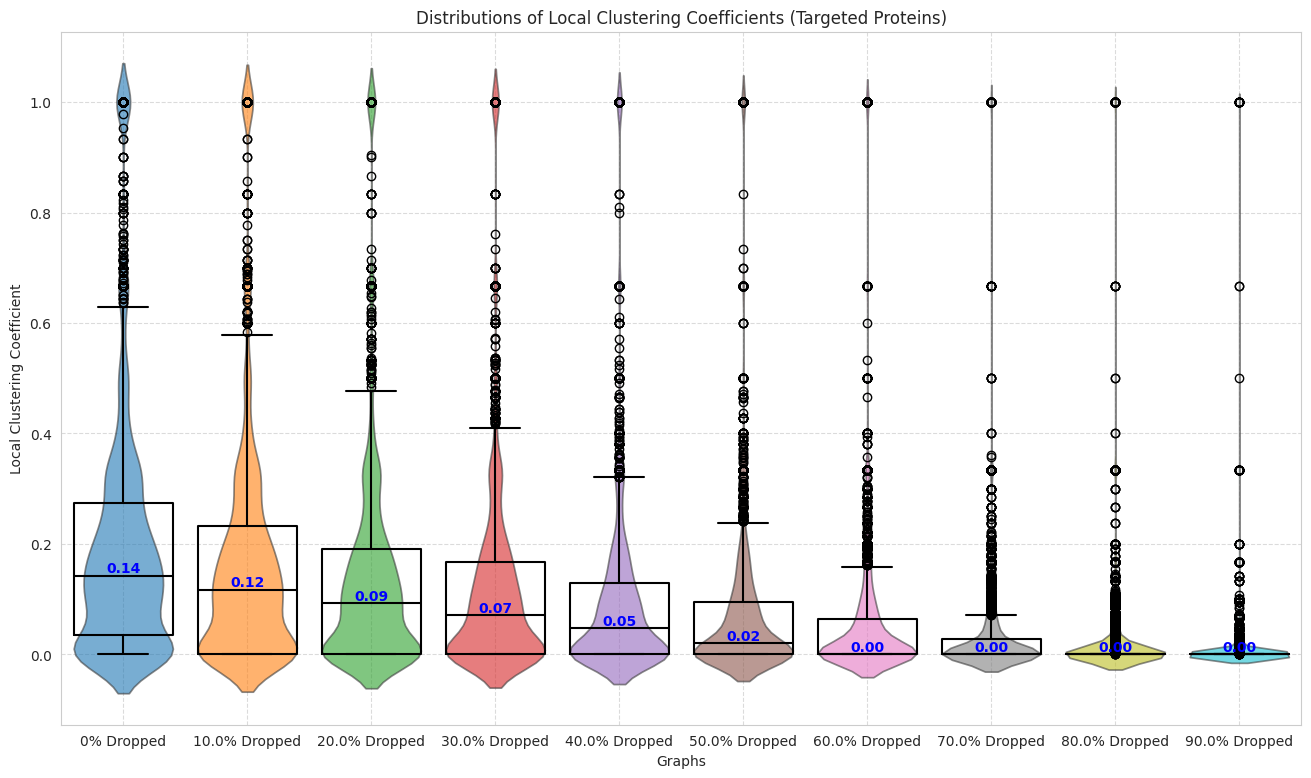

In [12]:
plt.figure(figsize=(16, 9))
sns.boxplot(data=neighbor_df, x="Graph", y="Local Clustering Coefficient", legend=False, fill=False, color='black')
sns.violinplot(data=neighbor_df, x="Graph", y="Local Clustering Coefficient", hue='Graph', inner=None, alpha=0.6, legend=False, saturation=1)

# Calculate medians and add annotations (ChatGPT)
medians = neighbor_df.groupby(['Graph'])['Local Clustering Coefficient'].median().values
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.2f}', ha='center', va='bottom', color='blue', fontweight='bold')


plt.xlabel("Graphs")
plt.ylabel("Local Clustering Coefficient")
plt.title("Distributions of Local Clustering Coefficients (Targeted Proteins)")
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

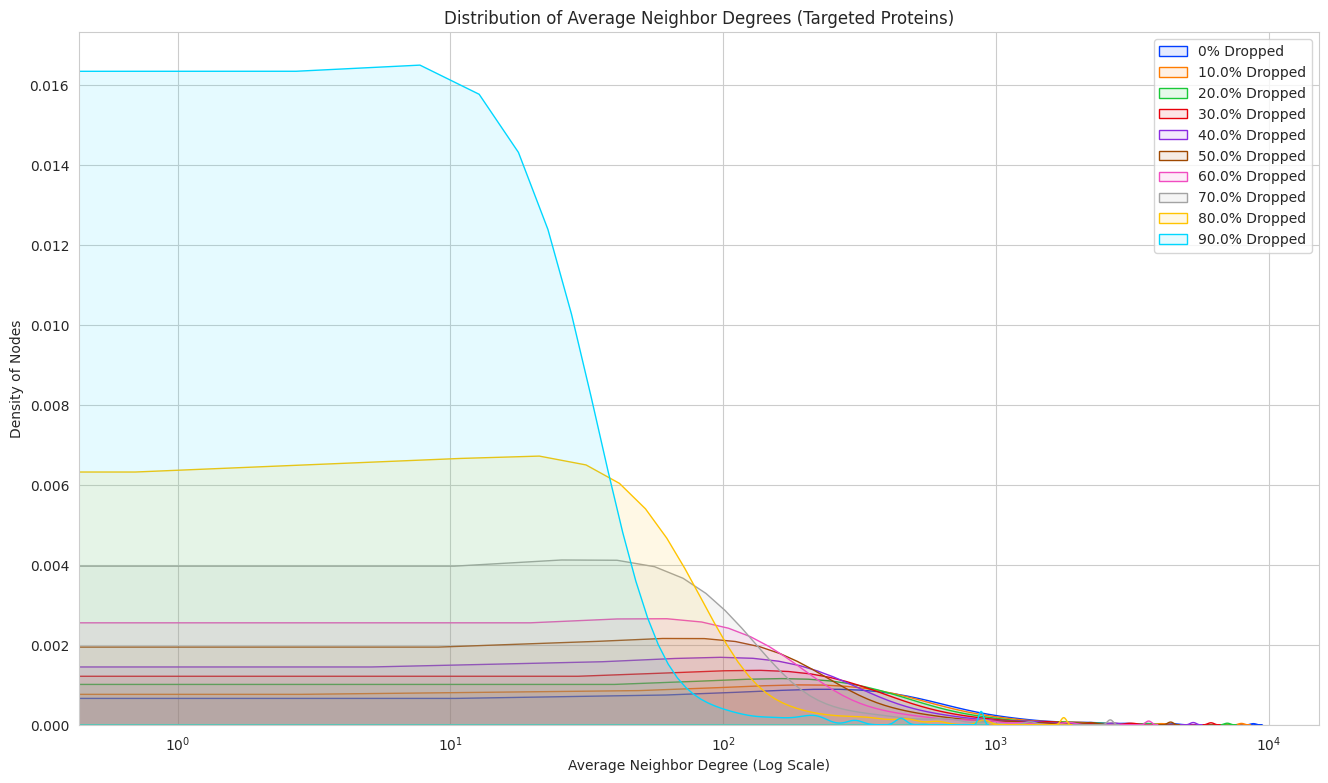

In [15]:
plt.figure(figsize=(16, 9))

for label, color in zip(labels, colors):
    test_df = neighbor_df.loc[neighbor_df['Graph'] == label, ['Average Neighbor Degree']]
    sns.kdeplot(test_df["Average Neighbor Degree"], color=color, label=label, fill = True, alpha=0.1)
    
plt.ylabel("Density of Nodes")
plt.xlabel("Average Neighbor Degree (Log Scale)")
plt.xscale('log')
plt.title("Distribution of Average Neighbor Degrees (Targeted Proteins)")
plt.legend()
plt.show()